# Decaying isomerization

The decaying isomerization process is the reversible interconversion of two isometric species $S_1$ and $S_2$ combined with the (typically much slower) decay of $S_2$ to a third spcies $S_3$:

$$ S_1 \leftrightarrows S_2 \qquad k_\text{forward} = c_1, k_\text{reverse} = c_2$$
$$ S_2 \to S_3 \qquad k = c_3 $$

As Rathinam [Rathinam 2003] and Gillespie [Gillespie 2008] note, for appropriately chosen parameters, the decaying isomerization problem is the simplest example of a "stiff" problem in chemical kinetics.

In the reversible isomerization process $ S_1 \leftrightarrows S_2$ alone, the random variable describing the number of $S_2$ specimens at equilibrium ($t \to \infty$) is:

$$ P(\# S_2 = x_2) = \text{Binomial}\left(\frac{c1}{c1 + c2}; x_T\right) (x_2) $$

where $x_T$ is the total inital specimens of $S_1$ and $S_2$ combined. (Gillespie 2008).

The relaxation time is defined as the characteristic time for the exponential approach of a perturbed system to its equilibrium. (The characteristic time being the time it takes for the exponential function to be reduced to a fraction $1/e$ of itself.)

In [21]:
import numpy as np
import pandas as pd
from reactionmodel.model import Species, Reaction, Model

In [20]:
from tests.discover import discover_tests

decaying_isomerization_tests = discover_tests('./', './decaying_isomerization', include_check=True)

Extending test suite from ././decaying_isomerization

less_stiff_short_initial_ss_ss
less_stiff_short_ss
less_stiff_long_initial_ss_ss
less_stiff_long_ss
less_stiff_short_initial_ss_hybrid
less_stiff_short_hybrid
less_stiff_long_initial_ss_hybrid
less_stiff_long_hybrid
stiff_short_initial_ss_ss
stiff_short_ss
stiff_long_initial_ss_ss
stiff_long_ss
stiff_short_initial_ss_hybrid
stiff_short_hybrid
stiff_long_initial_ss_hybrid
stiff_long_hybrid
ss_less_stiff_short_initial_ss_ss
ss_less_stiff_short_ss
ss_less_stiff_long_initial_ss_ss
ss_less_stiff_long_ss
ss_less_stiff_short_initial_ss_hybrid
ss_less_stiff_short_hybrid
ss_less_stiff_long_initial_ss_hybrid
ss_less_stiff_long_hybrid
ss_stiff_short_initial_ss_ss
ss_stiff_short_ss
ss_stiff_long_initial_ss_ss
ss_stiff_long_ss
ss_stiff_short_initial_ss_hybrid
ss_stiff_short_hybrid
ss_stiff_long_initial_ss_hybrid
ss_stiff_long_hybrid


In [19]:
decaying_isomerization_tests

[]

In [22]:
S1 = Species('S1')
S2 = Species('S2')
S3 = Species('S3')

reactions = [
    Reaction([S1], [S2], k='c1'),
    Reaction([S2], [S1], k='c2')
]

m = Model([S1, S2], reactions)

reactions.append(
    Reaction([S2], [S3], k='c3')
)

m_decay = Model([S1, S2, S3], reactions)

p = {'c1': 1, 'c2':1}
p_decay = {'c1': 1.0, 'c2': 2.0, 'c3': 5 * 1e-5} # gillespie 2008 figure 5
#p_decay = {'c1': 1.0, 'c2': 2.0, 'c3': 0}

t_span = [0.0, 20000]

initial_dictionary = {'S1': 1200, 'S2': 600, 'S3':0}

ic = m_decay.make_initial_condition(initial_dictionary)

def end_routine(result):
    return m_decay.y_to_dict(result.y)

## Slow-scale stochastic simulation

In [23]:
S12 = Species('S12')
S3  = Species('S3')

reactions = [
    Reaction([S12], [S3], k='c1*c3/(c1+c2)')
]

m_ss = Model([S12, S3], reactions)

ic_ss = m_ss.make_initial_condition({'S12': initial_dictionary['S1']+initial_dictionary['S2'], 'S3': initial_dictionary['S3']})

def sample_y(y_ss, m, p):
    y_dict = {}
    y_ss_dict = m.y_to_dict(y_ss)
    y_dict['S3'] = y_ss_dict['S3']
    y_dict['S2'] = np.random.binomial(y_ss_dict['S12'], p['c1']/(p['c1'] + p['c2']))
    y_dict['S1'] = y_ss_dict['S12'] - y_dict['S2']
    return y_dict

In [24]:
from hybrid.gillespie import GillespieSimulator

g_ss = GillespieSimulator(
    m_ss.get_k(parameters=p_decay, jit=True),
    m_ss.stoichiometry(),
    m_ss.kinetic_order(),
)

Evaluating expression: c1*c3/(c1+c2) => 0.016666666666666666


In [7]:
def ss_end_routine(result):
    return sample_y(result.y, m_ss, p_decay)

ss_df = pd.DataFrame(g_ss.run_simulations(200, t_span, ic_ss, np.random.default_rng(), end_routine=ss_end_routine))
ss_df

,S3,S2,S1
0,1747.0,12,41.0
1,1741.0,20,39.0
2,1731.0,23,46.0
3,1739.0,21,40.0
4,1726.0,25,49.0
...,...,...,...
195,1735.0,24,41.0
196,1741.0,15,44.0
197,1731.0,21,48.0
198,1737.0,23,40.0


<Axes: >

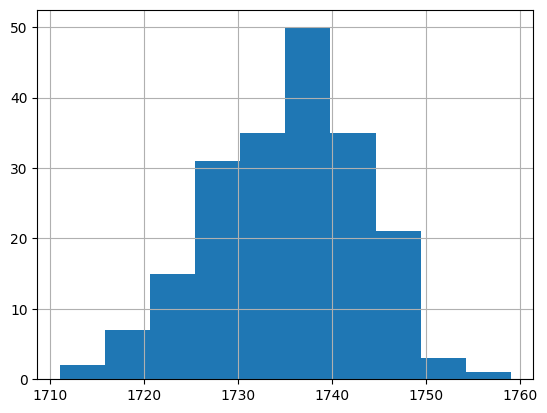

In [8]:
ss_df['S3'].hist()

In [25]:
from hybrid.parse import PreconfiguredSimulatorLoader

loader = PreconfiguredSimulatorLoader.load_preconfigured('hybrid_n')

In [26]:
hc_s = loader.make_simulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 0.05


In [11]:
#pd.DataFrame(hc_s.run_simulations(1, t_span, ic, np.random.default_rng(), end_routine=end_routine))

## Hybrid

In [27]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

h_s = HybridSimulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
    FixedThresholdPartitioner(100.0),
    fast_scale='langevin',
    approximate_rtot=True,
    contrived_no_reaction_rate=100.,
    euler_maruyama_timestep=0.01,
    round='randomly',
)

standard_gillespie_s = GillespieSimulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),    
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 0.05
Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 0.05


<Axes: >

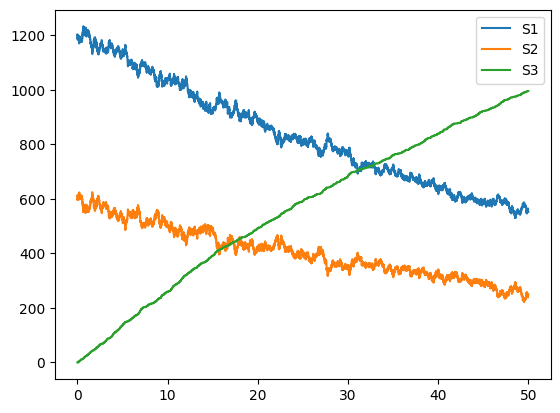

In [29]:
result = h_s.simulate([0, 50], ic, np.random.default_rng())
result.plot(m_decay.legend())

<Axes: >

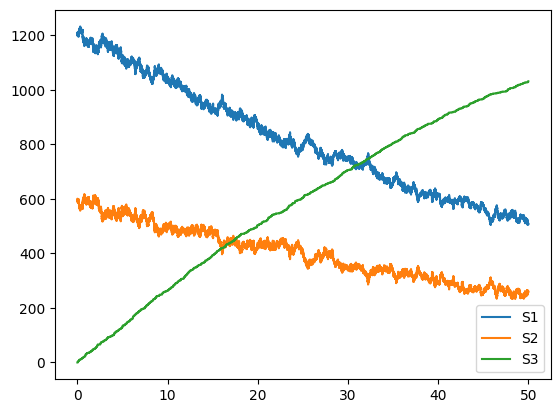

In [30]:
g_result = standard_gillespie_s.simulate([0, 50], ic, np.random.default_rng())
g_result.plot(m_decay.legend())

KstestResult(statistic=0.01171864836858745, pvalue=1.6039661040611016e-11, statistic_location=1164.9906531236202, statistic_sign=1)


KstestResult(statistic=0.055834999429204, pvalue=1.590462761433696e-53, statistic_location=1192.0, statistic_sign=1)

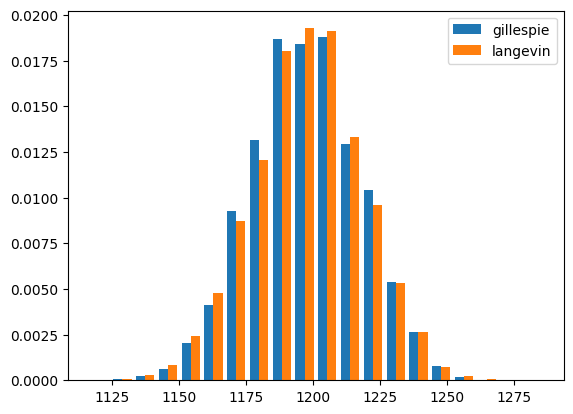

In [15]:
import matplotlib.pyplot as plt
from scipy.stats import kstest

cle_distribution = result.y_history[0, :]
gillespie_dist = g_result.y_history[0, :]

with_ss = False

labels = ['gillespie', 'langevin']
dists = [gillespie_dist, cle_distribution]
ss_distribution = 1800-np.random.binomial(1800, p_decay['c1']/(p_decay['c1'] + p_decay['c2']), size=20000)

if with_ss:
    labels.append('ss')
    dists.append(ss_distribution)
plt.hist(dists, label=labels, density=True, bins=20)
plt.legend(labels)

print(kstest(cle_distribution, gillespie_dist))
kstest(gillespie_dist, ss_distribution)

KstestResult(statistic=0.005250000000000005, pvalue=0.944300662533024, statistic_location=1181, statistic_sign=-1)

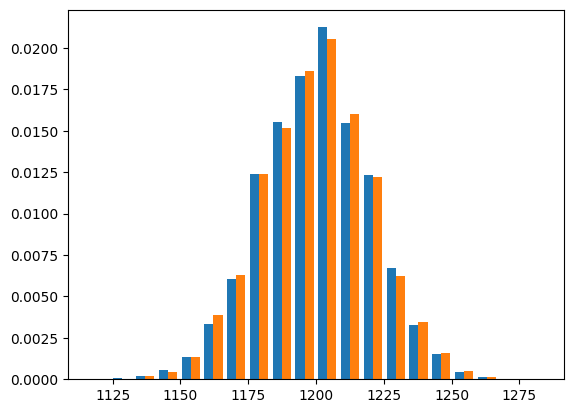

In [16]:
test_one = 1800-np.random.binomial(1800, p_decay['c1']/(p_decay['c1'] + p_decay['c2']), size=20000)
test_two = 1800-np.random.binomial(1800, p_decay['c1']/(p_decay['c1'] + p_decay['c2']), size=20000)

plt.hist([test_one, test_two], label=['t1', 't2'], density=True, bins=20)

kstest(test_one, test_two)

In [ ]:
len(cle_distribution), np.mean(cle_distribution), np.var(cle_distribution)

In [ ]:
len(gillespie_dist), np.mean(gillespie_dist), np.var(gillespie_dist)

## Tau leaping

In [9]:
from hybrid.tau import TauLeapSimulator

t_s = TauLeapSimulator(
    m_decay.get_k(parameters=p_decay, jit=True),
    m_decay.stoichiometry(),
    m_decay.kinetic_order(),
    method='explicit',
    epsilon=0.01
)

Evaluating expression: c1 => 1.0
Evaluating expression: c2 => 2.0
Evaluating expression: c3 => 5e-05


In [15]:
result = t_s.simulate(t_span, ic, np.random.default_rng(), history_length=1e8)

/Users/thayer/develop/hybrid/hybrid/tau.py:279: RuntimeWarning: invalid value encountered in divide
  tau1 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1) / np.abs(mu_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:280: RuntimeWarning: invalid value encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:279: RuntimeWarning: overflow encountered in divide
  tau1 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1) / np.abs(mu_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:280: RuntimeWarning: divide by zero encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:280: RuntimeWarning: overflow encountered in square
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))


<Axes: >

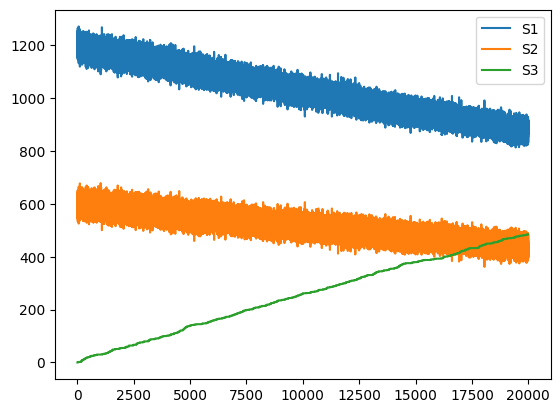

In [16]:
result.plot(m_decay.legend())

In [ ]:
sum(result.y_history[:, -1])

In [ ]:
import matplotlib.pyplot as plt
taus = [result.t_history[i+1] - result.t_history[i] for i in range(len(result.t_history)-1)]
plt.hist(np.array(taus))

In [ ]:
tau_df = pd.DataFrame(t_s.run_simulations(120, t_span, ic, np.random.default_rng(), end_routine=end_routine))

In [ ]:
tau_df['S3'].hist()

In [ ]:
from scipy.stats import kstest

kstest(tau_df['S3'], ss_df['S3'])

In [ ]:
result = t_s.simulate(t_span, ic, np.random.default_rng())

In [ ]:
result.plot(m_decay.legend())
result.status_counter

# Immigration + linear death process

In [ ]:
from reactionmodel.model import Species, Reaction, Model
from hybrid.gillespie import GillespieSimulator

S1 = Species('S1')

reactions = [
    Reaction([S1], [], k='r'),
    Reaction([], [S1], k='p')
]

m = Model([S1], reactions)

p = {'r': 1, 'p':100}

s = GillespieSimulator(
    m.get_k(parameters=p, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

In [ ]:
import numpy as np
result = s.simulate([0.0, 28.0], m.make_initial_condition({'S1': 100}), np.random.default_rng())
ax = result.plot(['Y_s'])
ax.axhline(100, color='r', linestyle='dashed')

In [ ]:
import matplotlib.pyplot as plt
#plt.hist(result.y_history)

In [ ]:
import pandas as pd
r = pd.DataFrame(data={'S': np.squeeze(result.y_history.T)})
r

In [ ]:
import scipy.stats

ax = plt.subplot()
x = np.arange(r.min().iloc[0], r.max().iloc[0])

ax.plot([x[0] for x in r.value_counts(normalize=True).sort_index().index.to_numpy()], r.value_counts(normalize=True).sort_index().to_numpy())
#ax = r.value_counts(normalize=True).sort_index().plot()

rv = scipy.stats.poisson(p['p']/p['c1'])
ax.plot(x, rv.pmf(x))

# Test discovery

In [ ]:
import tests.discover as discover

discover.discover_tests('./', include_check=True)

# Simple experiment idea:

Let's say you have a latent reservoir of size $n$ with variance $v$. As a function of the variance in the reservoir size, how much variance is there in the time until you hit exponential growth? How much variation is there in the re-seeded latent reservoir after a phase of $R_0$ that lasts for $t$ days?

=> how does this translate to your conclusions about probability of mutant emergence given a set standard?
=> how 